In this notebook I will create a contour map of the potentiometric surface for the T2 aquifer in the Northern Adelaide Plains (NAP) Prescribed Wells Area (PWA).

We will download the relevant data using this package (``python-sa-gwdata``) and use some other packages for other things:

- [polyline](https://pypi.org/projects/polyline) - for reading spatial data from WaterConnect
- [verde](https://pypi.org/projects/verde) - creating and plotting surfaces
- matplotlib, numpy, pandas and xarray - all used in the background

In [67]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from matplotlib import patches, ticker
import polyline
import verde as vd

import sa_gwdata

plt.style.use("bmh")
%matplotlib inline
plt.rcParams["figure.dpi"] = 120


In [2]:
%matplotlib inline
plt.rcParams["figure.dpi"] = 120

We can download a list of wells in the NAP using the [GetPWASearchData](https://python-sa-gwdata.readthedocs.io/en/latest/webservices.html#getpwasearchdata) endpoint. First we need to check what the correct reference is for the NAP:

In [3]:
session = sa_gwdata.WaterConnectSession()
session.pwas

{'Angas-Bremer': 'Angas-Bremer PWA',
 'Central Adelaide': 'Central Adelaide PWA',
 'Dry Creek': 'Dry Creek PWA',
 'Far North': 'Far North PWA',
 'Lower Limestone Coast': 'Lower Limestone Coast PWA',
 'Mallee': 'Mallee PWA',
 'McLaren Vale': 'McLaren Vale PWA',
 'Musgrave': 'Musgrave PWA',
 'Noora': 'Noora PWA',
 'Northern Adelaide Plains': 'Northern Adelaide Plains PWA',
 'Padthaway': 'Padthaway PWA',
 'Peake, Roby and Sherlock': 'Peake, Roby and Sherlock PWA',
 'Southern Basins': 'Southern Basins PWA',
 'Tatiara': 'Tatiara PWA',
 'Tintinara-Coonalpyn': 'Tintinara-Coonalpyn PWA'}

In [4]:
nap_wells = session.get("GetPWASearchData", params={"PWA": "Northern Adelaide Plains"}).gdf()
nap_wells.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5936 entries, 0 to 5935
Data columns (total 36 columns):
aq_mon               4940 non-null object
chem                 5936 non-null object
class                5936 non-null object
dhno                 5936 non-null int64
drill_date           4654 non-null object
hstratlog            5936 non-null object
lat                  5936 non-null float64
latest_open_date     5646 non-null object
latest_open_depth    5469 non-null float64
latest_sal_date      3608 non-null object
latest_swl_date      3142 non-null object
latest_yield_date    2967 non-null object
litholog             5936 non-null object
logdrill             5936 non-null object
lon                  5936 non-null float64
mapnum               5936 non-null float64
max_depth            5662 non-null float64
name                 1541 non-null object
nrm                  5936 non-null object
obsnetwork           1554 non-null object
obsnumber            469 non-null object


Let's also pull the boundary of the NAP in. We can get this from the WaterConnect API using [GetPWAFromName](https://python-sa-gwdata.readthedocs.io/en/latest/webservices.html#getpwafromname).

In [5]:
nap_info = session.get("GetPWAFromName", app="WDDWFS", params={"NAME": "Northern Adelaide Plains"})

In [6]:
coords = polyline.decode(nap_info.json[0]["Boundary"][0])
lats, lons = zip(*coords)

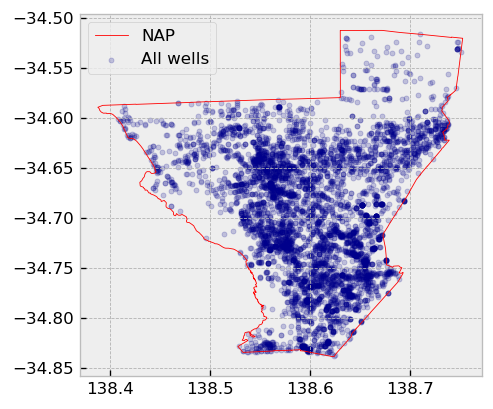

In [7]:
nap_wells.plot(marker=".", color="darkblue", alpha=0.2, label="All wells")
plt.plot(lons, lats, color="r", lw=0.5, label="NAP")
plt.legend()

OK. The problem with this is that in generating a potentiometric surface, we will also want to include measurement points outside of the area of interest. So let's try a different query. Let's increase the area, and then run a spatial query on WaterConnect instead.

In [8]:
range_lats = max(lats) - min(lats)
range_lons = max(lons) - min(lons)
min_lat = min(lats) - range_lats * 0.2
max_lat = max(lats) + range_lats * 0.1
min_lon = min(lons) - range_lons * 0.05
max_lon = max(lons) + range_lons * 0.1

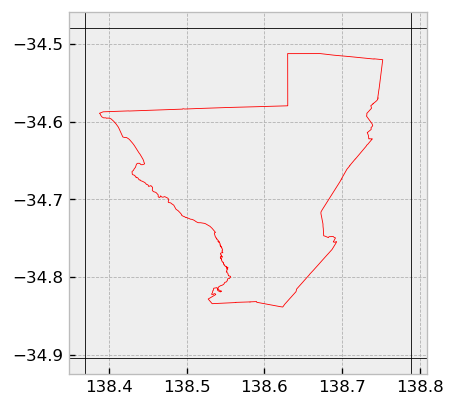

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect="equal")
ax.plot(lons, lats, color="r", lw=0.5, label="NAP")
for lon in (min_lon, max_lon):
    ax.axvline(lon, color="k", lw=0.5)
for lat in (min_lat, max_lat):
    ax.axhline(lat, color="k", lw=0.5)

In [10]:
spatial_query = session.get("GetGridData", params={"Box": ",".join([str(x) for x in (min_lat, min_lon, max_lat, max_lon)])}).gdf()
len(spatial_query)

10000

Oops. The length of 10,000 wells is a hard limit for WaterConnect. This means we have not received information about all the wells. We need to divide the space in smaller parts.

In [11]:
query_lats = np.linspace(min_lat, max_lat, 5)
query_lats

array([-34.903558  , -34.79764375, -34.6917295 , -34.58581525,
       -34.479901  ])

In [12]:
gdfs = []
for i in range(0, len(query_lats) - 1):
    query_gdf = session.get("GetGridData", params={"Box": ",".join([str(x) for x in (query_lats[i], min_lon, query_lats[i + 1], max_lon)])}).gdf()
    print(len(query_gdf))
    gdfs.append(query_gdf)
wells = pd.concat(gdfs)

8798
4620
3224
526


Next step

Filter to only those wells completed in the T2 aquifer.

In [13]:
wells.aq_mon.value_counts()[:10]

Qpah        5905
Qhcks       1814
Tomw(T2)    1537
Tomw(T1)     917
Qhck         520
T(T1)        494
Qa           301
Ndt          283
Nds          259
NE           183
Name: aq_mon, dtype: int64

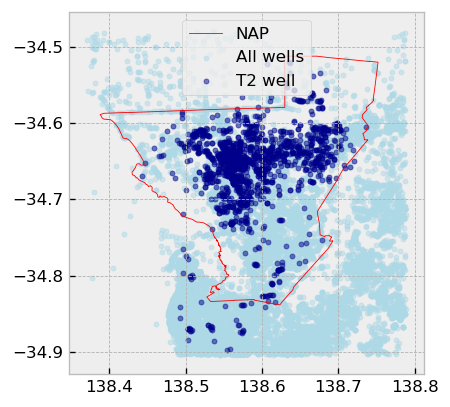

In [14]:
t2_wells = wells[wells.aq_mon == "Tomw(T2)"]

wells.plot(marker=".", color="lightblue", alpha=0.5, label="All wells")
t2_wells.plot(ax=plt.gca(), marker=".", color="darkblue", alpha=0.5, label="T2 well")
plt.plot(lons, lats, color="r", lw=0.5, label="NAP")
plt.legend()

The bulk download service names are currently undocumented, but the water level one is ``GetWaterLevelDownload``

In [70]:
df = session.bulk_download("GetWaterLevelDownload", {"DHNOs": [int(x) for x in t2_wells.dhno.values]})
locs = gpd.GeoSeries(gpd.points_from_xy(df.Easting, df.Northing))
locs.crs = {"init": "epsg:28354"}
df = gpd.GeoDataFrame(df, geometry=locs)
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 12018 entries, 0 to 12017
Data columns (total 21 columns):
DHNO               12018 non-null int64
network            11288 non-null object
Unit_Number        12018 non-null int64
Aquifer            12018 non-null object
Easting            12018 non-null float64
Northing           12018 non-null float64
Zone               12018 non-null int64
Unit_No            12018 non-null object
Obs_No             10706 non-null object
obs_date           12013 non-null object
swl                11840 non-null float64
rswl               11719 non-null float64
pressure           6 non-null float64
temperature        1 non-null float64
dry_ind            26 non-null object
anom_ind           12018 non-null object
pump_ind           12018 non-null object
measured_during    12018 non-null object
data_source        12018 non-null object
Comments           372 non-null object
geometry           12018 non-null object
dtypes: float64(6), int64(3), ob

Now, let's trim this list to exclude anom_ind = 'Y' and pump_ind = 'Y', to exclude known anomalous or pumping-affected measurements.

In [71]:
cleaned = df[(df.anom_ind == 'N') & (df.pump_ind == 'N')]

And let's convert the date columns into actual dates.

In [72]:
cleaned.obs_date.head(5)

0    24/04/1969
1    25/04/1969
2    28/04/1969
3    29/04/1969
4    12/05/1969
Name: obs_date, dtype: object

In [73]:
cleaned["obs_date"] = pd.to_datetime(cleaned.obs_date, format="%d/%m/%Y")
cleaned.obs_date.head(5)

0   1969-04-24
1   1969-04-25
2   1969-04-28
3   1969-04-29
4   1969-05-12
Name: obs_date, dtype: datetime64[ns]

Next step: calculate March potentiometric surfaces for each year.

In [74]:
recent_march = cleaned[(cleaned.obs_date.dt.month == 3) & (cleaned.obs_date.dt.year >= 2010)]
recent_march.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 465 entries, 234 to 12013
Data columns (total 21 columns):
DHNO               465 non-null int64
network            454 non-null object
Unit_Number        465 non-null int64
Aquifer            465 non-null object
Easting            465 non-null float64
Northing           465 non-null float64
Zone               465 non-null int64
Unit_No            465 non-null object
Obs_No             447 non-null object
obs_date           465 non-null datetime64[ns]
swl                457 non-null float64
rswl               445 non-null float64
pressure           0 non-null float64
temperature        0 non-null float64
dry_ind            5 non-null object
anom_ind           465 non-null object
pump_ind           465 non-null object
measured_during    465 non-null object
data_source        465 non-null object
Comments           7 non-null object
geometry           465 non-null object
dtypes: datetime64[ns](1), float64(6), int64(3), object(11)
m

Keep only the minimum water level measurements from each well, each year.

In [75]:
march_mins = recent_march.groupby([recent_march.obs_date.dt.year, "DHNO"]).apply(lambda x: x[x.rswl == x.rswl.min()])

And make sure that if any months had multiple minimum levels, just keep one of them:

In [76]:
march_mins = march_mins.groupby([march_mins.obs_date.dt.year, "DHNO"]).first()
march_mins

c:\devapps\python\anaconda3-32\envs\gwdev2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'DHNO' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


network  Unit_Number   Aquifer    Easting    Northing  \
obs_date DHNO                                                              
2010     27228         NAP    652800100  Tomw(T2)  267988.74  6166116.34   
         27380         NAP    652800252  Tomw(T2)  270699.77  6155197.32   
         27381         NAP    662821356  Tomw(T2)  271015.00  6158741.00   
         27382   CENT_ADEL    652800254  Tomw(T2)  270868.00  6150199.00   
         28228         NAP    652801100  Tomw(T2)  266036.00  6162521.00   
         48026         NAP    662800992  Tomw(T2)  272399.11  6165654.06   
         48100         NAP    662801066  Tomw(T2)  279797.00  6165035.00   
         48386     NAP_LIC    662801352  Tomw(T2)  283461.16  6166971.98   
         48409         NAP    662801375  Tomw(T2)  287520.00  6166892.00   
         48787         NAP    662801753  Tomw(T2)  289331.00  6168014.00   
         49252         NAP    662802218  Tomw(T2)  271068.15  6162975.04   
         49826         NAP    662802837  Tomw(T2)  284522.00  6159038.00   
         51965         NAP    662804996  Tomw(T2)  287509.00  6151780.00   
         52018         NAP    662805049  Tomw(T2)  283224.00  6150899.00   
         52072         NAP    662805103  Tomw(T2)  285578.80  6151385.29   
         55868   CENT_ADEL    662808899  Tomw(T2)  277780.72  6139287.06   
         58354   CENT_ADEL    662811385  Tomw(T2)  276503.00  6135636.00   
         58448   CENT_ADEL    662811479  Tomw(T2)  276092.15  6142001.96   
         60799         NAP    662813830  Tomw(T2)  274045.76  6157478.26   
         60803         NAP    662813834  Tomw(T2)  277983.81  6156376.24   
         60887         NAP    662813918  Tomw(T2)  278155.10  6163635.80   
         60888         NAP    662813919  Tomw(T2)  288511.82  6162752.34   
         60889         NAP    662813920  Tomw(T2)  274643.81  6164128.33   
         62174   CENT_ADEL    662815205  Tomw(T2)  272133.14  6146059.00   
         132399        NAP    662816257  Tomw(T2)  276330.10  6161309.20   
         135711        NAP    662816438  Tomw(T2)  286149.93  6160211.32   
         145631        NAP    662816712  Tomw(T2)  278939.00  6166701.00   
         164402        NAP    662818397  Tomw(T2)  277466.18  6163159.04   
         166252        NaN    662818571  Tomw(T2)  275936.93  6158518.31   
         168991        NAP    662818940  Tomw(T2)  281198.70  6166422.20   
...                    ...          ...       ...        ...         ...   
2018     60888         NAP    662813919  Tomw(T2)  288511.82  6162752.34   
         60889         NAP    662813920  Tomw(T2)  274643.81  6164128.33   
         62174   CENT_ADEL    662815205  Tomw(T2)  272133.14  6146059.00   
         132399        NAP    662816257  Tomw(T2)  276330.10  6161309.20   
         135711        NAP    662816438  Tomw(T2)  286149.93  6160211.32   
         145631        NAP    662816712  Tomw(T2)  278939.00  6166701.00   
         164402        NAP    662818397  Tomw(T2)  277466.18  6163159.04   
         168991        NAP    662818940  Tomw(T2)  281198.70  6166422.20   
         168992        NAP    662818941  Tomw(T2)  282859.50  6165273.40   
         170057        NAP    662819134  Tomw(T2)  276978.47  6154411.25   
         182169        NAP    662820328  Tomw(T2)  282065.12  6146758.98   
         182609        NAP    662820365  Tomw(T2)  284497.07  6171973.97   
         182610        NAP    662820366  Tomw(T2)  286809.15  6171947.05   
         182611        NAP    662820367  Tomw(T2)  286695.07  6176137.01   
         186848        NAP    662820666  Tomw(T2)  273662.60  6161485.90   
         187300        NAP    662820678  Tomw(T2)  282651.70  6163249.50   
         188557        NAP    662820729  Tomw(T2)  285822.50  6164562.20   
         188558        NAP    662820730  Tomw(T2)  281549.80  6160967.80   
         188559        NAP    662820731  Tomw(T2)  277800.40  6165481.70   
         188560        NAP    662820732  Tomw(T2)  279333.50  61685

In [77]:
df2018 = march_mins[march_mins.obs_date.dt.year == 2018].reset_index(drop=True)

Let's convert the NAP boundary from above into eastings and northings:

In [78]:
nap = gpd.GeoSeries(Polygon(zip(lons, lats)))
nap.crs = {"init": "epsg:4326"}
nap_utm = nap.to_crs({"init": "epsg:28354"})

And make a map of the 2018 March water level data.

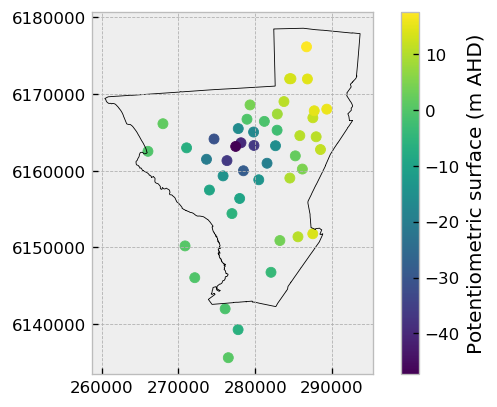

In [79]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect="equal")
cset = ax.scatter(df2018.Easting, df2018.Northing, c=df2018.rswl)
nap_utm.plot(ax=ax, facecolor="none", edgecolor="k")
cbar = plt.colorbar(cset)
cbar.set_label("Potentiometric surface (m AHD)")

Fit a surface to the data points using a spline:

In [81]:
spline = vd.Spline()
spline.fit((df2018.Easting, df2018.Northing), df2018.rswl)

Spline(damping=None, engine='auto',
       force_coords=(array([267988.74, 270868.  , 266036.  , 279797.  , 287520.  , 289331.  ,
       271068.15, 284522.  , 287509.  , 283224.  , 285578.8 , 277780.72,
       276503.  , 276092.15, 274045.76, 277983.81, 278155.1 , 288511.82,
       274643.81, 272133.14, 276330.1 , 286149.93, 278939.  , 277466.18,
       281198.7 , 282859.5 , 276978.47, 282065.12, 284497.07, 286809.15,
       286695.07, 273662.6 , 2...
       6151385.29, 6139287.06, 6135636.  , 6142001.96, 6157478.26,
       6156376.24, 6163635.8 , 6162752.34, 6164128.33, 6146059.  ,
       6161309.2 , 6160211.32, 6166701.  , 6163159.04, 6166422.2 ,
       6165273.4 , 6154411.25, 6146758.98, 6171973.97, 6171947.05,
       6176137.01, 6161485.9 , 6163249.5 , 6164562.2 , 6160967.8 ,
       6165481.7 , 6168566.3 , 6164416.8 , 6158815.8 , 6163286.8 ,
       6159987.9 , 6159321.7 , 6161930.  , 6169002.85, 6167379.41,
       6167803.  , 6171979.  ])),
       mindist=1e-05)

In [98]:
nap_utm.bounds.minx.values[0]

array([260420.60077432])

In [105]:
vmin, vmax = df2018.rswl.min(), df2018.rswl.max()

In [99]:
def region_from_df(df, xcol="Easting", ycol="Northing"):
    return df[xcol].min(), df[xcol].max(), df[ycol].min(), df[ycol].max()

def region_from_polygon(p):
    value = lambda x: p.bounds[x].values[0]
    return tuple(map(value, ("minx", "maxx", "miny", "maxy")))

In [114]:
surface_pts = vd.grid_coordinates(region_from_polygon(nap_utm), spacing=100)

In [115]:
potsurf = spline.predict(surface_pts)

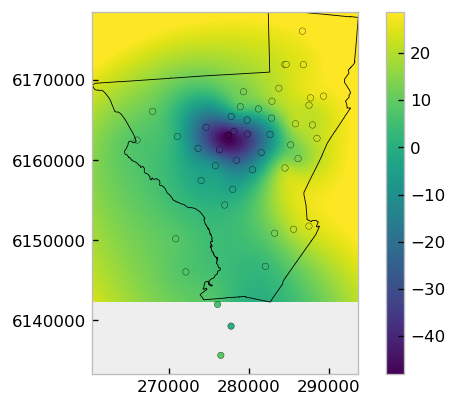

In [120]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect="equal")
cset_potsurf = ax.pcolormesh(surface_pts[0], surface_pts[1], potsurf, vmin=vmin, vmax=vmax)
cset_pts = ax.scatter(df2018.Easting, df2018.Northing, c=df2018.rswl, vmin=vmin, vmax=vmax, s=15, lw=0.2, edgecolor="k")
nap_utm.plot(ax=ax, facecolor="none", edgecolor="k")
plt.colorbar(cset)